Overview: Interferometer
------------------------

Alongside CCD `Imaging` data, the modeling of interferometer data from submillimeter and radio
observatories is implemented. The dataset is fitted directly in the uv-plane, circumventing issues that arise when fitting a `dirty
image` such as correlated noise.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from utils import fitutil as af
import utils as al
import utils.plot as aplt
from os import path
import numpy as np

/workspace
Working Directory has been set to `/workspace`


2021-10-13 16:53:08,637 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/fitutil/config
2021-10-13 16:53:08,682 - confutil.conf - WARNING - No configuration found at path /workspace/config


2021-10-13 16:53:08,736 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/utils/galaxyutil/config
2021-10-13 16:53:08,797 - confutil.conf - WARNING - No configuration found at path /workspace/config
2021-10-13 16:53:08,820 - confutil.conf - WARNING - Pushing new config with path /workspace/utils/config
2021-10-13 16:53:08,881 - confutil.conf - WARNING - No configuration found at path /workspace/config


__Real Space Mask__

To begin, we define a real-space mask. Although interferometer lens modeling is performed in the uv-plane and 
therefore Fourier space, we still need to define the grid of coordinates in real-space from which the lensed source's 
images are computed. It is this image that is mapped to Fourier space to compare to the uv-plane data.

In [2]:
real_space_mask = al.Mask2D.circular(
    shape_native=(400, 400), pixel_scales=0.025, radius=3.0
)

__Dataset__

We next load an interferometer dataset from fits files, which follows the same API that we have seen for an `Imaging`
object.

In [3]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)

The plot module has tools for plotting interferometer datasets, including the visibilities, noise-map
and uv wavelength which represent the interferometer`s baselines. 

The data used in this tutorial contains 1 million visibilities and is representative of an ALMA dataset:

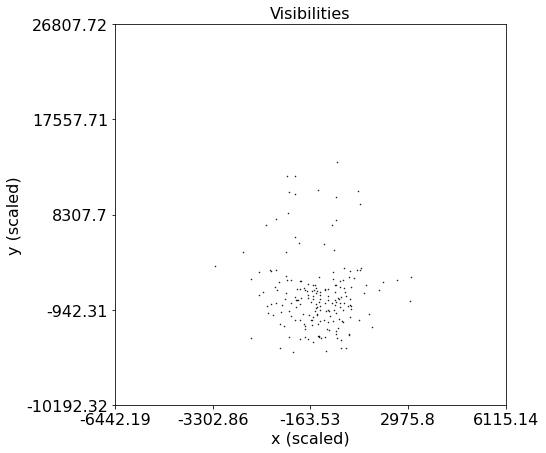

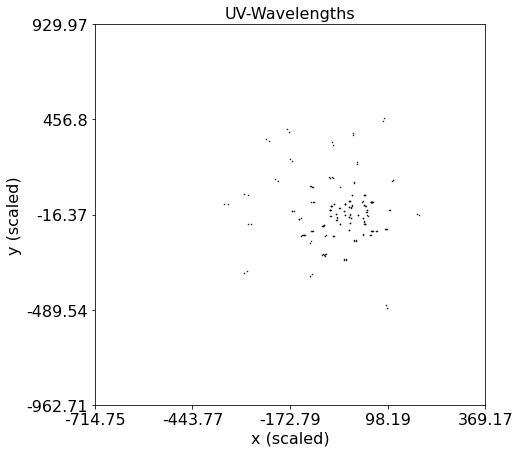

In [4]:
interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.figures_2d(visibilities=True, uv_wavelengths=True)


__Tracer__

To perform uv-plane modeling, we generate an image of the strong lens system in real-space via a `Tracer`. 

Lets quickly set up the `Tracer` we'll use in this example.

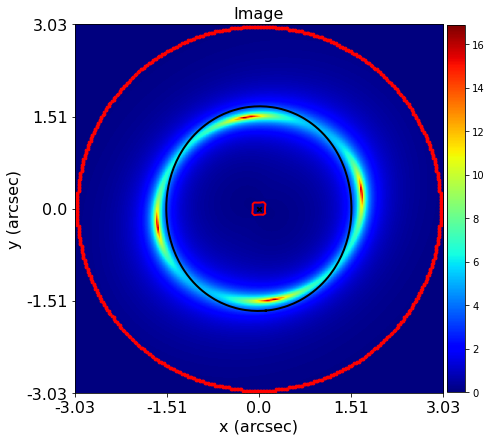

In [5]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

tracer_plotter = aplt.TracerPlotter(
    tracer=tracer, grid=real_space_mask.masked_grid_sub_1
)
tracer_plotter.figures_2d(image=True)

__UV-Plane__

To perform uv-plane modeling, we next Fourier transforms this image from real-sapce to the uv-plane.
This operation uses a *Transformer* object, of which there are multiple available. This includes
a direct Fourier transform which performs the exact Fourier transformw without approximation.

In [6]:
transformer_class = al.TransformerDFT

However, the direct Fourier transform is inefficient. For ~10 million visibilities, it requires **thousands of seconds**
to perform a single transform. To model a lens, we'll perform tens of thousands of transforms, making this approach
unfeasible for high quality ALMA and radio datasets.

For this reason, we supports the non-uniform fast fourier transform algorithm
**PyNUFFT** (https://github.com/jyhmiinlin/pynufft), which is significantly faster, being able too perform a Fourier
transform of ~10 million in less than a second!

In [7]:
transformer_class = al.TransformerNUFFT

The use this transformer in a fit, we use the `apply_settings` method.

In [8]:
interferometer = interferometer.apply_settings(
    settings=al.SettingsInterferometer(transformer_class=transformer_class)
)

__Fitting__

The interferometer can now be used with a `FitInterferometer` object to fit it to a data-set:

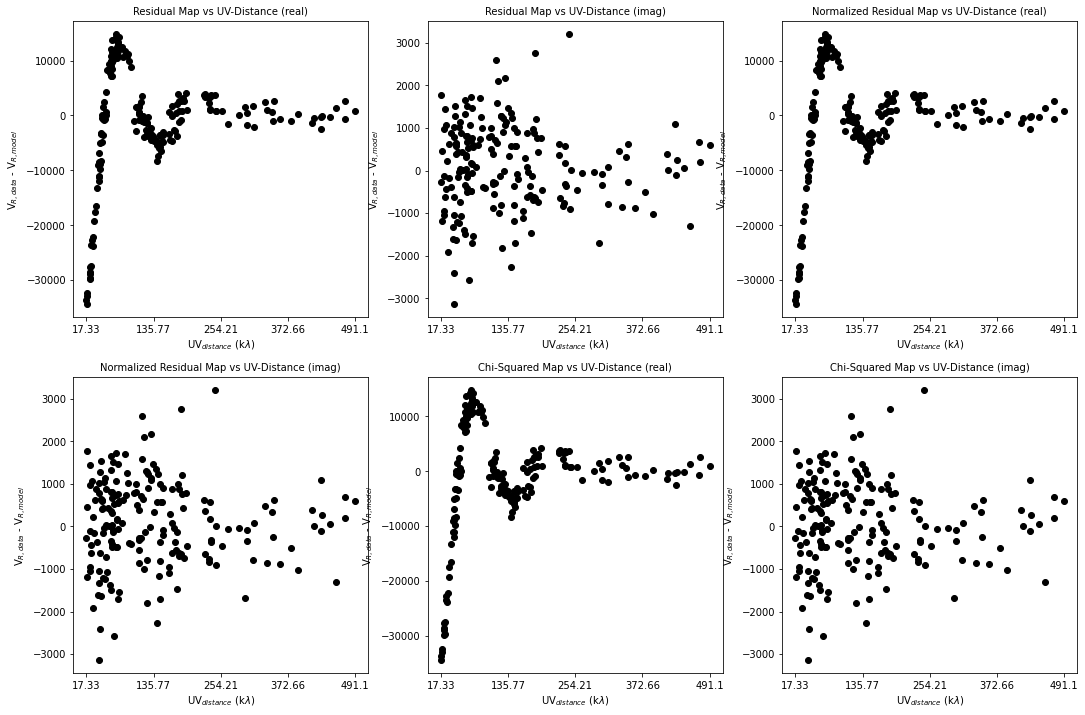

In [9]:
fit = al.FitInterferometer(interferometer=interferometer, tracer=tracer)

fit_interferometer_plotter = aplt.FitInterferometerPlotter(fit=fit)
fit_interferometer_plotter.subplot_fit_interferometer()

Interferometer data can also be modeled using pixelized source's, which again perform the source reconstruction by
directly fitting the visibilities in the uv-plane. The source reconstruction is visualized in real space:

Computing this source recontruction would be extremely inefficient if we use a traditional approach to
linear algebra which explicitly stored in memory the values required to solve for the source fluxes. In fact, for an
interferomter dataset of ~10 million visibilities this would require **hundreds of GB of memory**!

we use the library **PyLops** (https://pylops.readthedocs.io/en/latest/) to represent this calculation as
a sequence of memory-light linear operators.

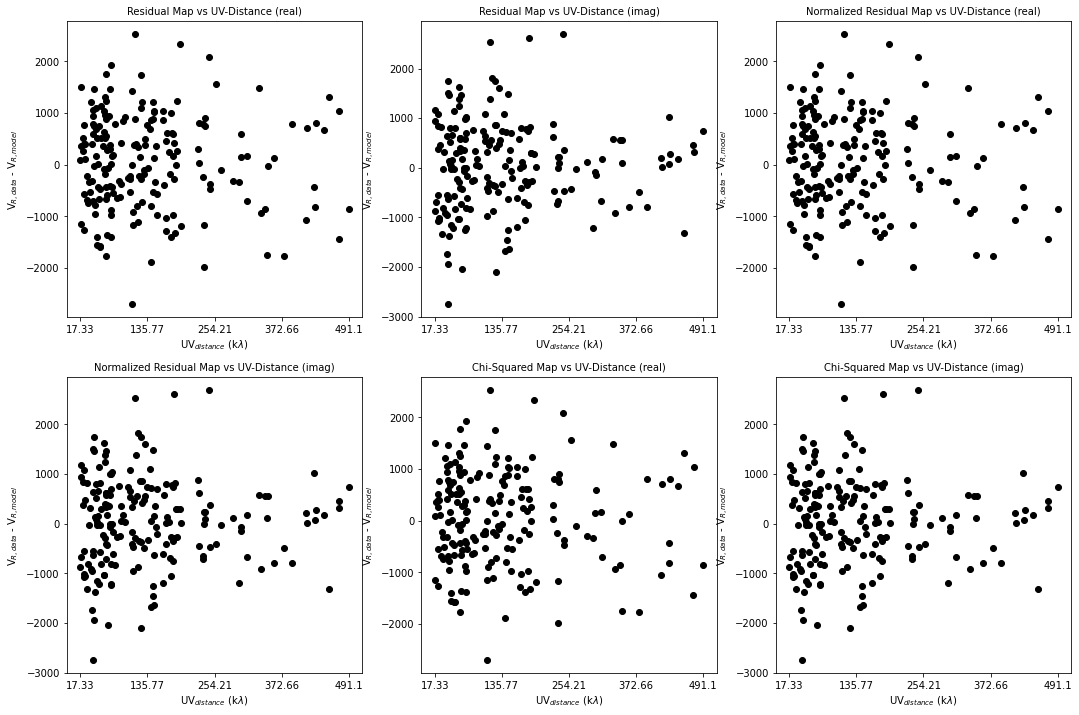

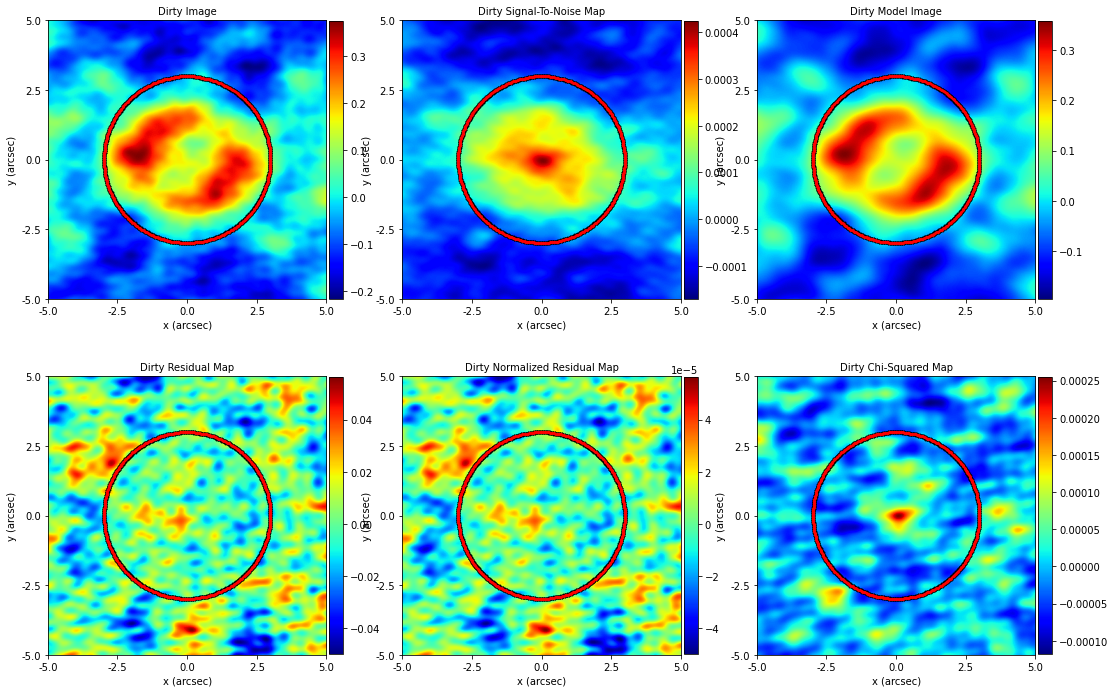

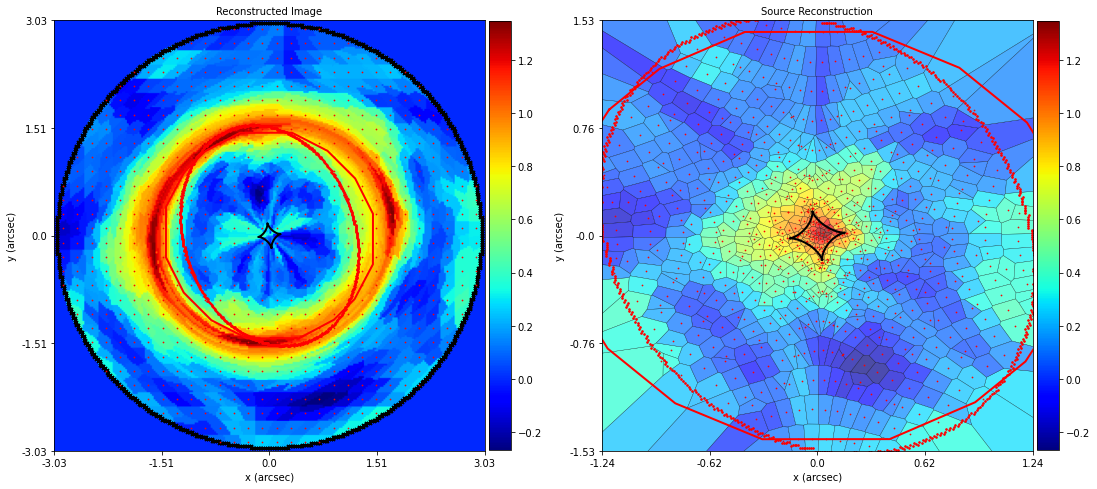

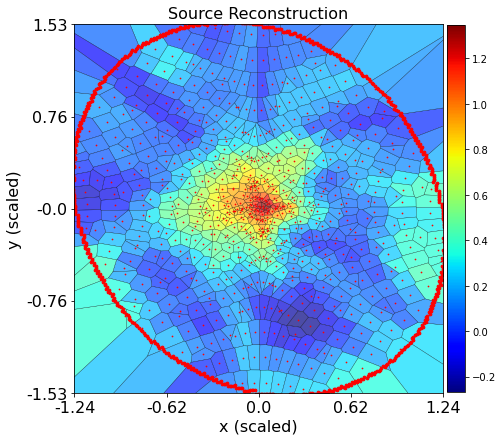

In [10]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitInterferometer(
    interferometer=interferometer,
    tracer=tracer,
    settings_inversion=al.SettingsInversion(use_linear_operators=True),
)

fit_interferometer_plotter = aplt.FitInterferometerPlotter(fit=fit)
fit_interferometer_plotter.subplot_fit_interferometer()
fit_interferometer_plotter.subplot_fit_dirty_images()
fit_interferometer_plotter.subplot_fit_real_space()

inversion_plotter = aplt.InversionPlotter(inversion=fit.inversion)
inversion_plotter.figures_2d(reconstruction=True)

__Lens Modeling__

We first compose the model:

In [11]:
lens_galaxy_model = af.Model(al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal)

source_galaxy_model = af.Model(al.Galaxy, redshift=1.0, disk=al.lp.EllExponential)

galaxies = af.Collection(lens=lens_galaxy_model, source=source_galaxy_model)
model = af.Collection(galaxies=galaxies)

__Non-linear Search__

We again choose the non-linear search `dynesty` (https://github.com/joshspeagle/dynesty).

In [12]:
search = af.DynestyStatic(name="overview_interferometer")

2021-10-13 16:53:22,258 - fitutil.non_linear.abstract_search - INFO - Creating search


__Analysis__

Whereas we previously used an `AnalysisImaging` object, we instead use an `AnalysisInterferometer` object which fits 
the lens model in the correct way for an interferometer dataset. 

This includes mapping the lens model from real-space to the uv-plane via the Fourier transform discussed above.

In [13]:
analysis = al.AnalysisInterferometer(dataset=interferometer)

__Model-Fit__

We can now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear
search to find which models fit the data with the highest likelihood.

The results can be found in the `output/overview_interferometer` folder in the workspace.

In [ ]:
result = search.fit(model=model, analysis=analysis)

__Result__

The visualization library and `FitInterferometer` object includes specific methods for plotting the 
results.

In [ ]:
fit_interferometer_plotter = aplt.FitInterferometerPlotter(
    fit=result.max_log_likelihood_fit
)
fit_interferometer_plotter.subplot_fit_interferometer()
fit_interferometer_plotter.subplot_fit_dirty_images()

__Simulation__3

Simulated interferometer datasets can be generated using the ``SimulatorInterferometer`` object, which includes adding
Gaussian noise to the visibilities:

In [ ]:
simulator = al.SimulatorInterferometer(
    uv_wavelengths=interferometer.uv_wavelengths,
    exposure_time=300.0,
    background_sky_level=1.0,
    noise_sigma=0.01,
)

real_space_grid = al.Grid2D.uniform(
    shape_native=real_space_mask.shape_native, pixel_scales=real_space_mask.pixel_scales
)

interferometer = simulator.from_tracer_and_grid(tracer=tracer, grid=real_space_grid)